In [1]:
import numpy as np
import graphinglib as gl
from collections import namedtuple
import astropy.units as u

from src.hdu.cubes.cube_co import CubeCO
from src.spectrums.spectrum_co import SpectrumCO
from src.spectrums.spectrum import Spectrum
from src.hdu.tesseract import Tesseract
from src.hdu.maps.grouped_maps import GroupedMaps
from src.hdu.maps.convenient_funcs import get_FWHM, get_speed
from src.coordinates.ds9_coords import DS9Coords

# Loop4N1

In [ ]:
N1 = CubeCO.load("data/Loop4_co/N1/Loop4N1_FinalJS.fits")[500:800,:,:].bin((1,2,2))
N1.header["COMMENT"] = "Loop4N1_FinalJS was binned 2x2."
N1.header["COMMENT"] = "Loop4N1_FinalJS was sliced at channel 500; all values of mean must then be " \
                        + "added to 500 to account for this shift."
# N1.save("data/Loop4_co/N1/Loop4N1_FinalJS_bin2.fits")

## Fitting

In [ ]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0.3,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 2,
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 6,
        "INITIAL_GUESSES_MAXIMUM_GAUSSIAN_STDDEV" : 10
    }

    chi2, fit_results = N1.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/N1/chi2.fits")
    fit_results.save("data/Loop4_co/N1/tesseract.fits")

## Slicing

In [ ]:
print(f"Targeted channel : {N1.header.get_coordinate(-4000, 0)}")
fit_results = Tesseract.load("data/Loop4_co/N1/tesseract.fits")

splits = ["lower_left", "lower_right", "upper"]
tesseract_splits = namedtuple("tesseract_splits", splits)
lower, upper = fit_results.split(14, 2)
lower_left, lower_right = lower.split(10, 3)
tesseract_splits = tesseract_splits(lower_left, lower_right, upper)

for split in splits:
    getattr(tesseract_splits, split).save(f"data/Loop4_co/N1/tesseract_splits/{split}.fits")

upper = tesseract_splits.upper.filter(slice(200, None))
lower_left = tesseract_splits.lower_left.filter(slice(197, None))
lower_right = tesseract_splits.lower_right.filter(slice(190, None))

lower = lower_left.concatenate(lower_right, 3)
total_object_N1 = lower.concatenate(upper, 2)

# Compressing the Tesseract
total_object_N1 = total_object_N1.compress()
total_object_N1.save(f"data/Loop4_co/N1/object.fits")

## Verifications

In [ ]:
total_object_N1 = Tesseract.load(f"data/Loop4_co/N1/object.fits")
fig = gl.Figure(size=(10,7), figure_style="dim")
fig.add_elements(*total_object_N1.get_spectrum_plot(N1, DS9Coords(11, 10)))
fig.show()

## Refits

In [ ]:
# Working in DS9Coods
spectrums = {
    (11, 10) : N1[:,*DS9Coords(11, 10)],
    (14, 10) : N1[:,*DS9Coords(14, 10)]
}

for coords, spectrum in spectrums.items():
    total_object_N1[0,*DS9Coords(*coords)] = np.NAN

total_object_N1.compress().save("data/Loop4_co/N1/object_filtered.fits")

# Loop4N2

In [ ]:
N2 = CubeCO.load("data/Loop4_co/N2/Loop4N2_Conv_Med_FinalJS_wcs.fits")[500:800,:,:]
N2.header["COMMENT"] = "Loop4N2_Conv_Med_FinalJS_wcs was sliced at channel 500; all values of mean must then be " \
                        + "added to 500 to account for this shift."

## Fitting

In [ ]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0.2,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 2,
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 5,
        "INITIAL_GUESSES_MAXIMUM_GAUSSIAN_STDDEV" : 7
    }

    chi2, fit_results = N2.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/N2/chi2.fits")
    fit_results.save("data/Loop4_co/N2/tesseract.fits")

## Slicing

In [ ]:
print(f"Targeted channel : {N2.header.get_coordinate(-3000, 0)}")
fit_results = Tesseract.load("data/Loop4_co/N2/tesseract.fits")

# total = fit_results.filter(slice(179, 240))


splits = ["left", "center", "right"]
tesseract_splits = namedtuple("tesseract_splits", splits)
left_center, right = fit_results.split(23, 3)       # right : >= 700
left, center = left_center.split(12, 3)             # left : >= 700, center : >= 684
    
tesseract_splits = tesseract_splits(left, center, right)

for split in splits:
    getattr(tesseract_splits, split).save(f"data/Loop4_co/N2/tesseract_splits/{split}.fits")

left = tesseract_splits.left.filter(slice(200, 230))
center = tesseract_splits.center.filter(slice(184, None))
right = tesseract_splits.right.filter(slice(200, None))

left_center = left.concatenate(center, 3)
total = left_center.concatenate(right, 3)

# Compressing the Tesseract
total = total.compress()
total.save(f"data/Loop4_co/N2/object.fits")

## Verifications

In [ ]:
total_object_N2 = Tesseract.load(f"data/Loop4_co/N2/object.fits")
fig = gl.Figure(size=(10,7), figure_style="dim")
fig.add_elements(*total_object_N2.get_spectrum_plot(N2, DS9Coords(16, 16)))
fig.show()

## Refits

In [ ]:
spectrum_parameters = {
    "PEAK_PROMINENCE" : 0.2,
    "PEAK_MINIMUM_DISTANCE" : 6,
    "PEAK_WIDTH" : 2,
    "INITIAL_GUESSES_BINNING" : 2,
    "MAX_RESIDUE_SIGMAS" : 5,
    "INITIAL_GUESSES_MAXIMUM_GAUSSIAN_STDDEV" : 7
}

# Working in DS9Coods
spectrums = {
    (16, 16) : N2[:,*DS9Coords(16, 16)],
    (17, 16) : N2[:,*DS9Coords(17, 16)],
}
[spectrum.setattrs(spectrum_parameters) for spectrum in spectrums.values()]

spectrums[(16, 16)].fit(); spectrums[(16, 16)].fit(); spectrums[(16, 16)].fit()
spectrums[(17, 16)].fit(); spectrums[(17, 16)].fit(); spectrums[(17, 16)].fit()

for coords, spectrum in spectrums.items():
    multi_fig = gl.MultiFigure(1, 1, title=coords, figure_style="dark", size=(10, 7))
    fig = gl.Figure()
    fig.add_elements(spectrum.plot, spectrum.initial_guesses_plot, *spectrum.individual_functions_plot,
                     spectrum.total_functions_plot)
    multi_fig.add_figure(fig, 0, 0, 1, 1)
    multi_fig.show()
    total_object_N2[0,*DS9Coords(*coords)] = np.NAN
    total_object_N2[1,*DS9Coords(*coords)] = np.NAN
    total_object_N2[2,*DS9Coords(*coords)] = np.NAN
    for i, fit_result in enumerate(spectrum.fit_results.to_numpy()[1:3]):   # Remove first and last components
        # Loop on all the fit results, removing the first component
        total_object_N2[i,*DS9Coords(*coords)] = fit_result

total_object_N2.compress().save("data/Loop4_co/N2/object_filtered.fits")

# Loop4N4

In [4]:
N4 = CubeCO.load("data/Loop4_co/N4/Loop4N4_Conv_Med_FinalJS_wcs.fits")[500:850,:,:]
N4.header["COMMENT"] = "Loop4N4_Conv_Med_FinalJS_wcs was sliced at channel 500; all values of mean must then be " \
                        + "added to 500 to account for this shift."

## Fitting

In [ ]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0.2,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 2,
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 5
    }

    chi2, fit_results = N4.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/N4/chi2.fits")
    fit_results.save("data/Loop4_co/N4/tesseract.fits")

## Slicing

In [6]:
print(f"Targeted channel : {N4.header.get_coordinate(1000, 0)}")
fit_results = Tesseract.load("data/Loop4_co/N4/tesseract.fits")

total = fit_results.filter(slice(135, 195))

# Compressing the Tesseract
total = total.compress()
total.save(f"data/Loop4_co/N4/object.fits")

Targeted channel : 147


RuntimeError: No active exception to reraise

## Verifications

In [ ]:
total_object_N4 = Tesseract.load(f"data/Loop4_co/N4/object.fits")
fig = gl.Figure(size=(10,7), figure_style="dim")
fig.add_elements(*total_object_N4.get_spectrum_plot(N4, DS9Coords(20, 5)))
fig.show()

## Refits

In [ ]:
# Working in DS9Coods
spectrums = {
    (29, 33) : N4[:,*DS9Coords(29, 33)],
    (23, 21) : N4[:,*DS9Coords(23, 21)],
    (24, 21) : N4[:,*DS9Coords(24, 21)],
    (22, 23) : N4[:,*DS9Coords(22, 23)],
}

spectrums[(29, 33)].setattrs({"PEAK_MINIMUM_DISTANCE" : 20}); spectrums[(29, 33)].fit()
spectrums[(23, 21)].setattrs({"PEAK_PROMINENCE" : 0.0, "PEAK_WIDTH" : 1}); spectrums[(23, 21)].fit()
spectrums[(24, 21)].setattrs({"PEAK_PROMINENCE" : 0.0, "PEAK_WIDTH" : 1}); spectrums[(24, 21)].fit()
spectrums[(22, 23)].setattrs({"PEAK_PROMINENCE" : 0.0, "PEAK_WIDTH" : 1, "PEAK_MINIMUM_DISTANCE" : 1}); spectrums[(22, 23)].fit()

for coords, spectrum in spectrums.items():
    multi_fig = gl.MultiFigure(1, 1, title=coords, figure_style="dark", size=(10, 7))
    fig = gl.Figure()
    fig.add_elements(spectrum.plot, spectrum.initial_guesses_plot, *spectrum.individual_functions_plot,
                     spectrum.total_functions_plot)
    multi_fig.add_figure(fig, 0, 0, 1, 1)
    multi_fig.show()
    total_object_N4[0,*DS9Coords(*coords)] = np.NAN
    total_object_N4[1,*DS9Coords(*coords)] = np.NAN
    total_object_N4[2,*DS9Coords(*coords)] = np.NAN
    for i, fit_result in enumerate(spectrum.fit_results.to_numpy()[:-1]):
        # Loop on all the fit results, removing the last component
        total_object_N4[i,*DS9Coords(*coords)] = fit_result

total_object_N4.save("data/Loop4_co/N4/object_filtered.fits")

# Loop4p

In [2]:
p = CubeCO.load("data/Loop4_co/p/Loop4p_Conv_Med_FinalJS_wcs.fits")[500:850,:,:].bin((1,2,2))
p.header["COMMENT"] = "Loop4p_Conv_Med_FinalJS_wcs was binned 2x2."
p.header["COMMENT"] = "Loop4p_Conv_Med_FinalJS_wcs was sliced at channel 500; all values of mean must then be " \
                    + "added to 500 to account for this shift."
# p.save("data/Loop4_co/p/Loop4p_Conv_Med_FinalJS_bin2.fits")

## Fitting

In [3]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0.4,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 2.5,
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 5
    }

    chi2, fit_results = p.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/p/chi2.fits")
    fit_results.save("data/Loop4_co/p/tesseract.fits")

Number of processes used: 8


Fitting: 100%|██████████| 30/30 [00:03<00:00,  7.93fit/s]


File overwritten.
File overwritten.


## Slicing

In [4]:
print(f"Targeted channel : {p.header.get_coordinate(0000, 0)}")
fit_results = Tesseract.load("data/Loop4_co/p/tesseract.fits")

total = fit_results.filter(slice(130, 205))

# Compressing the Tesseract
total = total.compress()
total.save(f"data/Loop4_co/p/object.fits")

Targeted channel : 163
File overwritten.


## Verifications

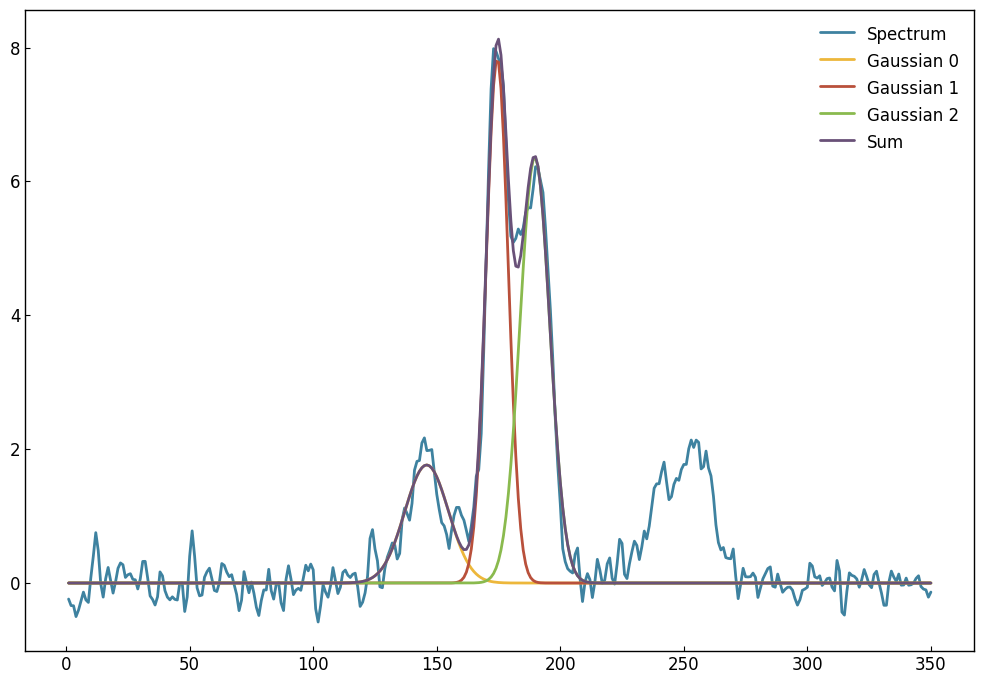

In [6]:
total_object_p = Tesseract.load(f"data/Loop4_co/p/object.fits")
fig = gl.Figure(size=(10,7))
fig.add_elements(*total_object_p.get_spectrum_plot(p, DS9Coords(10, 15)))
%matplotlib inline
# %matplotlib tk
fig.show()

## Refits

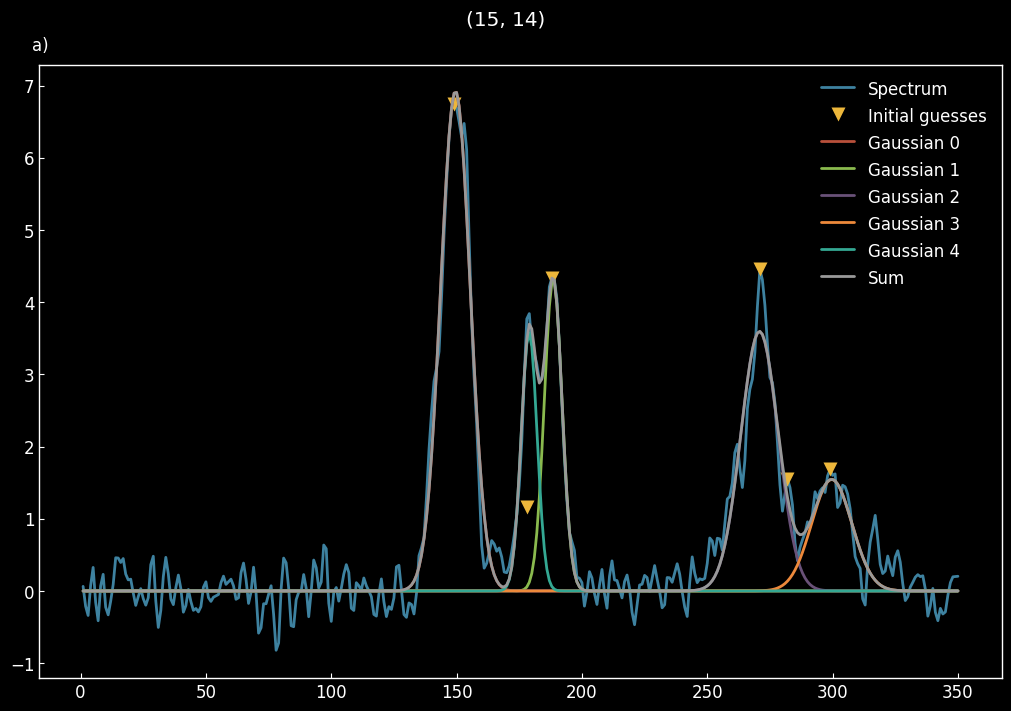

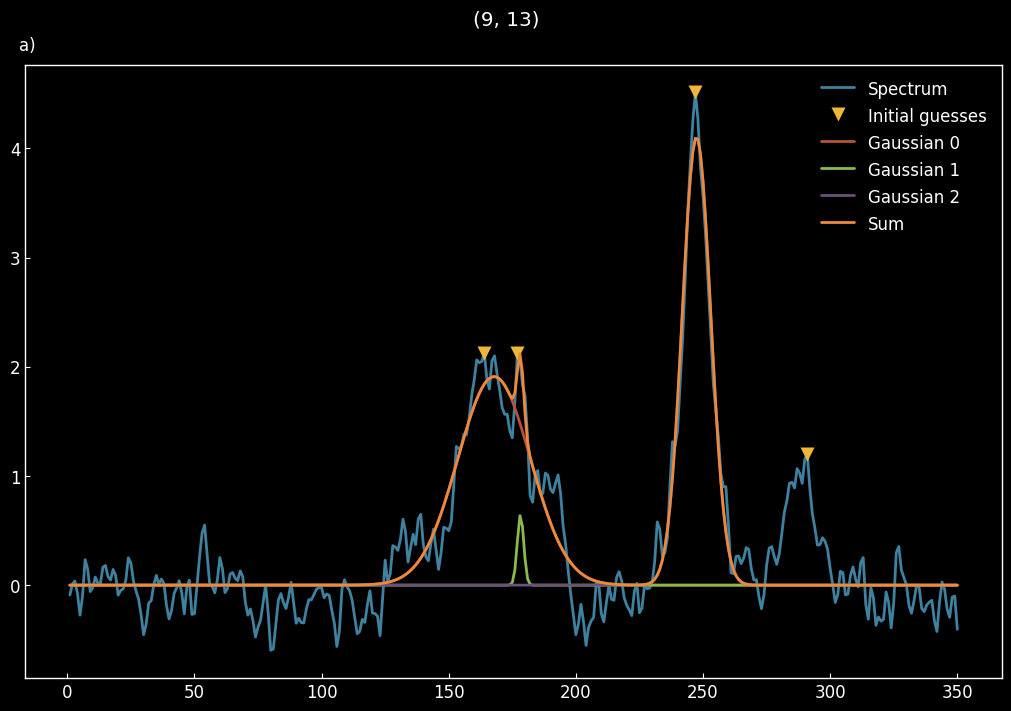

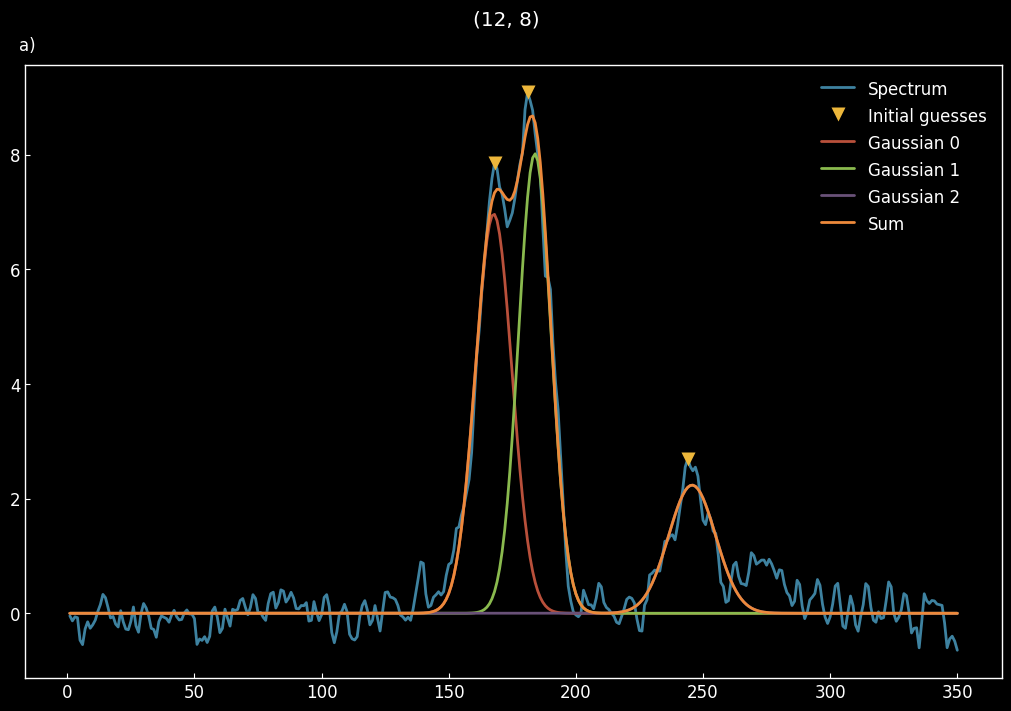

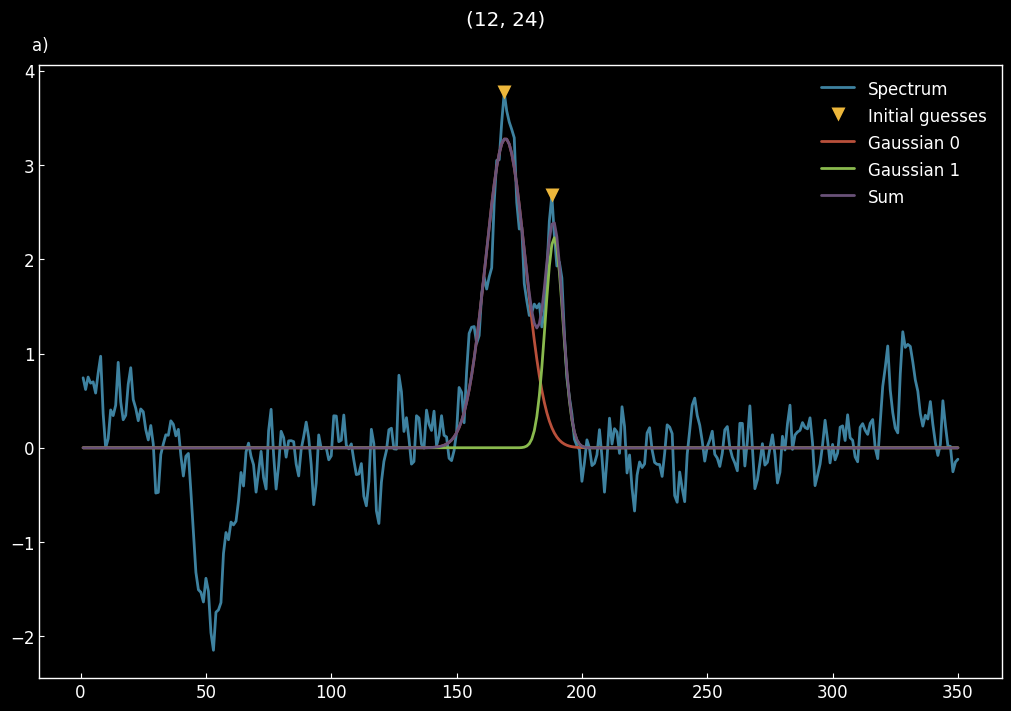

File overwritten.


In [5]:
total_object_p = Tesseract.load(f"data/Loop4_co/p/object.fits")
# Working in DS9Coods
spectrums = {
    (15, 14) : p[:,*DS9Coords(15, 14)],
    (9,  13) : p[:,*DS9Coords(9,  13)],
    (12, 8 ) : p[:,*DS9Coords(12, 8 )],
    (12, 24) : p[:,*DS9Coords(12, 24)],
}

spectrums[(15, 14)].setattrs({"PEAK_PROMINENCE" : 0.0, "PEAK_WIDTH" : 1})
spectrums[(15, 14)].fit()
spectrums[(15, 14)].fit()
spectrums[(9,  13)].setattrs({}); spectrums[(9,  13)].fit()
spectrums[(12, 8 )].setattrs({}); spectrums[(12, 8 )].fit()
spectrums[(12, 24)].setattrs({"NOISE_CHANNELS" : slice(70, 130)}); spectrums[(12, 24)].fit()

for coords, spectrum in spectrums.items():
    multi_fig = gl.MultiFigure(1, 1, title=coords, figure_style="dark", size=(10, 7))
    fig = gl.Figure()
    fig.add_elements(spectrum.plot, spectrum.initial_guesses_plot, *spectrum.individual_functions_plot,
                     spectrum.total_functions_plot)
    multi_fig.add_figure(fig, 0, 0, 1, 1)
    multi_fig.show()
    total_object_p[0,*DS9Coords(*coords)] = np.NAN
    total_object_p[1,*DS9Coords(*coords)] = np.NAN
    total_object_p[2,*DS9Coords(*coords)] = np.NAN
    total_object_p[3,*DS9Coords(*coords)] = np.NAN

# Loop on all the fit results, adapt the removed component(s) to every spectra
for i, fit_result in enumerate(spectrums[(15, 14)].fit_results.to_numpy()[:-2]):
    total_object_p[i,*DS9Coords(15, 14)] = fit_result
for i, fit_result in enumerate(spectrums[(9,  13)].fit_results.to_numpy()[:-1]):
    total_object_p[i,*DS9Coords(9,  13)] = fit_result
for i, fit_result in enumerate(spectrums[(12, 8 )].fit_results.to_numpy()[:-1]):
    total_object_p[i,*DS9Coords(12, 8 )] = fit_result
for i, fit_result in enumerate(spectrums[(12, 24)].fit_results.to_numpy()):
    total_object_p[i,*DS9Coords(12, 24)] = fit_result

total_object_p.save("data/Loop4_co/p/object_filtered.fits")

# Speed maps

In [2]:
clouds = {
    "N1" : {
        "tesseract" : "data/Loop4_co/N1/object_filtered.fits",
        "cube" : "data/Loop4_co/N1/Loop4N1_FinalJS.fits",
        "save_filename" : "speed_maps/N1_speed.fits",
    },
    "N2" : {
        "tesseract" : "data/Loop4_co/N2/object_filtered.fits",
        "cube" : "data/Loop4_co/N2/Loop4N2_Conv_Med_FinalJS_wcs.fits",
        "save_filename" : "speed_maps/N2_speed.fits",
    },
    "N4" : {
        "tesseract" : "data/Loop4_co/N4/object_filtered.fits",
        "cube" : "data/Loop4_co/N4/Loop4N4_Conv_Med_FinalJS_wcs.fits",
        "save_filename" : "speed_maps/N4_speed.fits",
    },
    "p" : {
        "tesseract" : "data/Loop4_co/p/object_filtered.fits",
        "cube" : "data/Loop4_co/p/Loop4p_Conv_Med_FinalJS_wcs.fits",
        "save_filename" : "speed_maps/p_speed.fits",
    },
}

for cloud, infos in clouds.items():
    gm = Tesseract.load(infos["tesseract"]).to_grouped_maps()
    cube = CubeCO.load(infos["cube"])

    speed_maps = []
    for map_ in gm.mean:
        speed_maps.append(get_speed(map_ + 500, cube))   # Add 500 to account for the previous cropping
    GroupedMaps([("centroid speed", speed_maps)]).save(infos["save_filename"], overwrite=True)